# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

---
# Projet H2023 : Prédiction du prix des diamants


La description du projet est disponible à l'adresse suivante : https://www.kaggle.com/t/2126c40a2d454beb8bd36d168581c968

Les fichiers utilisés sont les suivants :
- train.csv
- test.csv

Le fichier *train.csv* contient le prix de vente en dollar américain de 40 455 diamants en fonction des caractéristiques suivantes :

- cut : qualité de coupe (Fair, Good, Very Good, Premium, Ideal)
- color : couleur du diamant (de J (pire) à D (meilleure)
- clarity : clarté du diamant (I1 (pire), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (meilleure))
- x : longueur en mm 
- y : largeur en mm
- z : profondeur en mm
- depth : pourcentage de la profondeur exprimée comme 2*z/(x+y)
- table : pourcentage de la largeur du sommet du diamant par rapport au point le plus large 

Le fichier test.csv contient les caractéristiques de 13 485 diamants pour lesquels nous allons prédire le prix de vente.

In [ ]:
using CSV, DataFrames, Gadfly, GLM, Statistics, StatsBase, MLBase, Distributions, Random, Combinatorics, LinearAlgebra
import Plots

---
## 1. Chargement de données

Dans cette section, nous allons importer les données du fichier "train.csv" dans un dataframe qui sera utilisé pour l'entraînement des modèles statistiques.

Avant d'explorer les données, nous allons supprimer la colonne "ID" car le dataframe fournit un index automatique pour chaque observation. En supprimant cette colonne, nous simplifions notre analyse en enlevant une variable redondante qui n'apporte pas d'informations supplémentaires.

In [ ]:
train = CSV.read("train.csv", DataFrame)
select!(train, Not(:ID))
first(train, 5)

---
## 2. Analyse exploratoire et préparation des données

Tout d'abord, nous allons effectuer une analyse exploratoire pour nous familiariser avec les données. Cette analyse nous permettra de mieux comprendre les caractéristiques du diamant et d'identifier les problèmes potentiels. Nous allons examiner la distribution des données, la présence de données manquantes ou aberrantes, et toute autre relation importante.

Ensuite, nous allons effectuer une préparation des données pour l'entraînement des modèles statistiques. Nous allons remplacer les valeurs manquantes par des valeurs appropriées en fonction de la caractéristique. Nous allons également supprimer les valeurs aberrantes qui pourraient fausser l'analyse. Cette étape est cruciale pour s'assurer que les modèles statistiques seront correctement entraînés.

Nous allons ensuite effectuer une analyse individuelle de chaque caractéristique pour mieux comprendre leur impact sur le prix. Nous allons utiliser des dataframes et des diagrammes pour visualiser leur distribution et leur relation avec le prix. Pour les caractéristiques qualitatives, nous allons utiliser des histogrammes et des diagrammes en boîte et pour les caractéristiques quantitatives, nous allons utiliser des diagrammes de dispersion.

Enfin, nous allons effectuer des analyses globales sur les données pour vérifier la corrélation et la multicolinéarité. Nous allons utiliser la matrice de corrélation pour examiner les relations entre les caractéristiques et identifier toute corrélation élevée. Nous allons également utiliser un processus de sélection des variables explicatives pour choisir les caractéristiques les plus importantes en fonction de leur influence sur le prix. Ce processus nous permettra de sélectionner le meilleur modèle à tester en fonction du coefficient de détermination.

#### 2.1 Prix en fonction des variables qualitatives (coupe, couleur, clarté)

Tout d'abord, nous avons constaté que la caractéristique "cut" présentait des valeurs manquantes. Pour éviter de retirer ces observations et de manquer de données pour générer le fichier de prédictions, nous avons initialement considéré les valeurs manquantes comme une qualité "Missing" à part entière. Cependant, cette approche a conduit à des résultats de prédiction peu précis. Nous avons donc remplacé les valeurs manquantes par le mode de la coupe, c'est-à-dire la coupe Ideal.

Ensuite, pour utiliser ces variables qualitatives dans notre modèle, nous les avons transformées en variables quantitatives. Nous avons d'abord remplacé chaque valeur qualitative par une valeur numérique, technique mise en place pour les modèles de régression linéaire simple 1 et 2. Dans le but de s'améliorer, nous avons utilisé le one-hot encoding ou encodage 1 parmi n pour intégrer ces variables qualitatives dans le modèle. Le one-hot encoding est une technique qui permet de représenter une variable catégorielle sous forme d'un vecteur binaire. Pour chaque catégorie, on crée une variable indicatrice qui prend la valeur 1 si la catégorie correspondante est présente, et 0 sinon.

Pour la qualité de la coupe, nos recherches bibliographiques nous ont laissé supposer que les diamants avec une coupe de meilleure qualité se vendent à un prix plus élevé que ceux avec une coupe de moins bonne qualité [1][2]. Pour tester cette hypothèse, nous avons intégré cette variable qualitative dans le modèle en utilisant une combinaison de variables indicatrices : Ideal, Premium, Very Good et Good (Fair étant 0).

Pour la couleur, nos recherches bibliographiques nous ont laissé supposer que les diamants moins colorés se vendent à un prix plus élevé que ceux plus colorés [3]. Pour tester cette hypothèse, nous avons intégré cette variable qualitative dans le modèle en utilisant une combinaison de variables indicatrices : D, E, F, H et I (J étant 0).

Enfin, pour la clarté, nos recherches bibliographiques nous ont laissé supposer que les diamants avec une meilleure clarté se vendent à un prix plus élevé que ceux avec une moins bonne clarté [4]. Pour tester cette hypothèse, nous avons intégré cette variable qualitative dans le modèle en utilisant une combinaison de variables indicatrices : IF, VVS1, VVS2, VS1, VS2, SI1 et SI2 (I1 étant 0).

In [ ]:
# COMPTEUR DES VALEURS MANQUANTES
sum(ismissing.(train.cut))
sum(ismissing.(train.color)) # AUCUNE
sum(ismissing.(train.clarity)) # AUCUNE

# REMPLACEMENT DES VALEURS MANQUANTES
mode_cut = mode(skipmissing(train.cut))
train.cut = coalesce.(train.cut, mode_cut)

# IMPLÉMENTATION DES VARIABLES INDICATRICES DE LA QUALITÉ DE COUPE
train[:, :Ideal] = [Int64(train.cut[i] == "Ideal") for i in 1:nrow(train)]
train[:, :Premium] = [Int64(train.cut[i] == "Premium") for i in 1:nrow(train)]
train[:, :VeryGood] = [Int64(train.cut[i] == "Very Good") for i in 1:nrow(train)]
train[:, :Good] = [Int64(train.cut[i] == "Good") for i in 1:nrow(train)]

# PRÉSENTATION DES DIAGRAMMES DE LA QUALITÉ DE COUPE
plots = Vector{Plot}()
for col in [:cut, :Ideal, :Premium, :VeryGood, :Good]
    push!(plots, plot(train, x=col, Geom.histogram))
    push!(plots, plot(train, x=col, y=:price, Geom.boxplot))
end
set_default_plot_size(40cm, 20cm)
gridstack(reshape(plots, (2, 5)))

Les histogrammes permettent de déterminer la fréquence de chaque niveau.
Dans ce cas-ci, le premier histogramme a permis d'observer que la qualité de coupe la plus répandue était Ideal, suivie par les catégories Premium, Very Good, Good et Fair (environ 18 000 diamants ayant une coupe Ideal, moins de 10 000 diamants pour Premium et Very Good, et moins de 5 000 pour Good et Fair). Le fait que la catégorie Ideal soit la plus répandue (avec un pourcentage de 45%) et la plus équilibrée en termes de répartition, montre qu'elle elle est bel et bien un bon choix pour remplacer les valeurs manquantes.

Les diagrammes en boîte permettent de visualiser la distribution des prix en fonction de chaque niveau de la variable qualitative et ils permettent de déterminer la médiane, le premier et le troisième quartile, ainsi que les données aberrantes. 
Dans ce cas-ci, les diagrammes en boîte ont permis de constater que les prix des diamants étaient les plus élevés dans la catégorie Premium, suivi par les catégories Fair, Very Good, Good et Ideal. Ils ont également montré que la médiane et le trosième quartile pour la catégorie Ideal étaient moins élevés que ceux des autres caractéristiques. On peut donc conclure que la qualité de coupe semble avoir un certain impact sur le prix des diamants mais, il n'est pas possible d'affirmer que le prix possède une relation linéaire avec la qualité de coupe.

In [ ]:
# IMPLÉMENTATION DES VARIABLES INDICATRICES DE LA COULEUR
train[:, :D] = [Int64(train.color[i] == "D") for i in 1:nrow(train)]
train[:, :E] = [Int64(train.color[i] == "E") for i in 1:nrow(train)]
train[:, :F] = [Int64(train.color[i] == "F") for i in 1:nrow(train)]
train[:, :G] = [Int64(train.color[i] == "G") for i in 1:nrow(train)]
train[:, :H] = [Int64(train.color[i] == "H") for i in 1:nrow(train)]
train[:, :I] = [Int64(train.color[i] == "I") for i in 1:nrow(train)]

# PRÉSENTATION DES DIAGRAMMES DE LA COULEUR
plots = Vector{Plot}()
for col in [:color, :D, :E, :F, :G, :H, :I]
    push!(plots, plot(train, x=col, Geom.histogram))
    push!(plots, plot(train, x=col, y=:price, Geom.boxplot))
end
set_default_plot_size(60cm, 20cm)
gridstack(reshape(plots, (2, 7)))

Le premier histogramme a permis d'observer que la couleur la plus courante est G, suivie de près par E, F, H et D, qui représentent plus de 5 000 diamants chacune. Les catégories I et J viennent ensuite, avec respectivement plus de 3 000 et moins de 2 500 diamants. Il est intéressant de noter qu'ici, aucune couleur n'est également réparties.

Les diagrammes en boîte ont permis de constater que le classement des couleurs en fonction du prix médian et du trosième quartile des diamants est J, I, H, G, F, D et E, ce qui est similaire à l'ordre décroissant. Les couleurs les "moins colorées" sont donc, contrairement à ce qu'on peut penser, moins chères. On peut donc conclure que la couleur semble avoir un certain impact sur le prix des diamants mais, il n'est pas possible d'affirmer que le prix possède une relation linéaire avec la couleur.

In [ ]:
# IMPLÉMENTATION DES VARIABLES INDICATRICES DE LA CLARTÉ
train[:, :IF] = [Int64(train.clarity[i] == "IF") for i in 1:nrow(train)]
train[:, :VVS1] = [Int64(train.clarity[i] == "VVS1") for i in 1:nrow(train)]
train[:, :VVS2] = [Int64(train.clarity[i] == "VVS2") for i in 1:nrow(train)]
train[:, :VS1] = [Int64(train.clarity[i] == "VS1") for i in 1:nrow(train)]
train[:, :VS2] = [Int64(train.clarity[i] == "VS2") for i in 1:nrow(train)]
train[:, :SI1] = [Int64(train.clarity[i] == "SI1") for i in 1:nrow(train)]
train[:, :SI2] = [Int64(train.clarity[i] == "SI2") for i in 1:nrow(train)]

# PRÉSENTATION DES DIAGRAMMES DE LA CLARTÉ
plots = Vector{Plot}()
for col in [:clarity, :IF, :VVS1, :VVS2, :VS1, :VS2, :SI1, :SI2]
    push!(plots, plot(train, x=col, Geom.histogram))
    push!(plots, plot(train, x=col, y=:price, Geom.boxplot))
end
set_default_plot_size(80cm, 20cm)
gridstack(reshape(plots, (2, 8)))

Le premier histogramme a permis d'observer que la clarté la plus courante est SI1, suivie de VS2, SI2 et VS1, avec plus de 5 000 diamants pour chaque catégorie. Les clartés VVS2, VVS1, IF et I1 sont ensuite recensées dans l'ordre. On voit ici aussi, qu'aucune clarté n'est également répartie.

Les diagrammes en boîte ont permis de constater que le classement des couleurs en fonction du prix médian et du trosième quartile des diamants est VS1, VS2, SI1, SI2, I1, VVS2, VVS1 et IF, ce qui est similaire à l'ordre décroissant. Les couleurs les "moins colorées" sont donc, contrairement à ce qu'on peut penser, moins chères. On peut donc conclure que la couleur semble avoir un certain impact sur le prix des diamants mais, il n'est pas possible d'affirmer que le prix possède une relation linéaire avec la couleur comme on le supposait précédemment dans notre hypothèse.

Dans le cadre des derniers modèles de régression linéaire simple, une étape optionnelle consiste à retirer les variables sous leur forme qualitative une fois les variables encodées. En effet, celles-ci ne sont plus nécessaires à la modélisation, la suppression des variables sous leur forme qualitative peut avoir un impact significatif sur les résultats de la modélisation et sur la capacité à interpréter les résultats de manière efficace. Néanmoins, il est important de souligner que ces variables ont été utilisées pour tester les deux premiers modèles.

In [ ]:
select!(train, Not([:cut, :color, :clarity]))
first(train, 5)

#### 2.2 Prix en fonction des variables quantitatives (longueur, largeur, profondeur)

Tout d'abord, nous avons constaté que la caractéristique y présentait des valeurs manquantes. Pour éviter de retirer ces observations et de manquer de données pour générer le fichier de prédictions, nous avons initialement remplacé les valeurs manquantes par la moyenne de y. Toutefois, nous avons finalement opté pour remplacer les valeurs manquantes par la valeur de x associée à la valeur manquante de y, car nous avons remarqué que ces valeurs sont toujours très proches ce qui n'est pas toujours le cas avec la moyenne de y.

Ensuite, dans un souci d'élimination des données aberrantes qui pourraient affecter négativement l'analyse statistique, nous avons supprimé les observations dont les valeurs de la variable "x" étaient inférieures à 3.8, les valeurs de la variable y étaient inférieures à 3.67 ou supérieures à 9.38, et les valeurs de la variable z étaient inférieures à 2.3 ou supérieures à 5.91. Cette étape a été effectuée en analysant les fichiers csv, dans le but de conserver le maximum de données, nous n'avons enlevé que les valeurs isolées.

In [ ]:
# COMPTEUR DES VALEURS MANQUANTES
sum(ismissing.(train.x)) # AUCUNE
sum(ismissing.(train.y))
sum(ismissing.(train.z)) # AUCUNE

# REMPLACEMENT DES VALEURS MANQUANTES DE Y
train.y = coalesce.(train.y, train.x)

# SUPRESSION DES VALEURS ABERRANTES DE X, Y ET Z
filter!(row -> !(row.x < 3.8 || row.y < 3.77 || row.y > 9.38 || row.z < 2.3 || row.z > 5.91), train)

# PRÉSENTATION DES DIAGRAMMES DE X, Y ET Z
Plots.plot(
    Plots.plot(train.x, train.price, seriestype=:scatter, xlabel="longueur (en mm)", ylabel="prix", label=""),
    Plots.plot(train.y, train.price, seriestype=:scatter, xlabel="largeur (en mm)", ylabel="prix", label=""),
    Plots.plot(train.z, train.price, seriestype=:scatter, xlabel="profondeur (en mm)", ylabel="prix", label=""),
    layout=(1, 3),
    size=(900, 400),
    margin=5mm,
)

Les nuage de points représentent chaque observation de la relation entre deux variables sous la forme de points. En analysant la forme des nuages de points, il est possible de déduire les relations entre le prix des diamants et ces variables.
En les visualisant, nous avons constaté une corrélation positive entre le prix et chacune des trois variables, ce qui suggère que les diamants avec les plus grandes dimensions ont tendance à être plus chers. Toutefois, nous avons également observé une grande dispersion des prix pour une même combinaison de valeurs de longueur, de largeur et de profondeur. Il est donc clair que ces variables ne sont pas les seules déterminantes du prix des diamants.

Après avoir analysé la distribution des variables quantitatives de notre jeu de données, nous avons remarqué qu'il pourrait y avoir des relations non linéaires entre la longueur, la largeur, la profondeur et le prix des diamants. Afin de mieux capturer ces relations et de faciliter l'interprétation des résultats, nous avons choisi d'ajouter les variables x2, y2 et z2, qui représentent les valeurs au carré de x, y et z respectivement. Cette transformation nous permet de créer une forme linéaire pour ces variables et facilite leur interprétation dans le cadre de notre analyse de régression.

In [ ]:
# AJOUT DES VARIABLES AU CARRÉ
train[!, "x2"] = train.x.*train.x
train[!, "y2"] = train.y.*train.y
train[!, "z2"] = train.z.*train.z

# PRÉSENTATION DES DIAGRAMMES DE X2, Y2 ET Z2
Plots.plot(
    Plots.plot(train.x2, train.price, seriestype=:scatter, xlabel="longueur2 (en mm)", ylabel="prix", label=""),
    Plots.plot(train.y2, train.price, seriestype=:scatter, xlabel="largeur2 (en mm)", ylabel="prix", label=""),
    Plots.plot(train.z2, train.price, seriestype=:scatter, xlabel="profondeur2 (en mm)", ylabel="prix", label=""),
    layout=(1, 3),
    size=(900, 400),
    margin=5mm,
)

Les diagrammes ont montré que les points se répartissent selon une droite de type exponentiel pour les variables x, y et z, ainsi que pour les variables x2, y2 et z2. Ces observations suggèrent que le prix des diamants est une fonction exponentielle de ces variables. Cette tendance est particulièrement marquée pour les variables au carré, ce qui renforce l'idée que la transformation au carré de ces variables a permis de capturer des relations non linéaires importantes.

#### 2.3 Ajout du prix en fonction du carat et du carat au carré

D'après nos recherches bibliographiques, le prix du diamant dans le commerce est traditionnellement déterminé en fonction des "4C" : la coupe, la couleur, la clarté et le carat [2]. C'est pourquoi nous avons inclus la variable carat dans notre modèle, car elle est facilement mesurable à partir des dimensions (x, y et z) [5]. Nous avons calculé le carat en utilisant deux formules différentes, mais après des tests rigoureux, nous avons constaté que la différence entre les deux formules était négligeable. Nous avons donc opté pour la formule courte, qui approxime le diamant à un simple cône et ne nécessite pas l'utilisation de la table (voir Annexe 1). En effet, cette formule réduit le temps de calcul et minimise les risques d'erreurs de calcul, qui sont plus élevés avec la formule longue qui calcule le volume exact du diamant en supposant la hauteur de couronne égale à 15% de la hauteur totale (voir Annexe 2).

Bien que le volume de chaque diamant soit pris en compte dans notre modèle grâce au carat, nous avons conservé les dimensions (x, y et z) ainsi que leurs carrés (x2, y2 et z2) comme variables explicatives. En effet, si un diamant d'un carat supérieur a logiquement plus de valeur, ses dimensions jouent également un rôle important. Par exemple, un diamant très allongé (avec une hauteur z considérablement plus grande que les côtés x et y) pourrait se vendre moins cher qu'un diamant correctement proportionné pour un même volume.

In [ ]:
# AJOUT DU CARAT FORMULE LONGUE
# train[!, "volume"] = π*train.x.*train.y.*train.z.*(1 .- 0.85 .* train.table .* 0.01 .- 0.15 .* train.table .* 0.01 .*train.table .* 0.01 .*train.table .* 0.01)./(12 .*(1 .- train.table .* 0.01))
# train[!, "carat"] = (3.5 .*train.volume)./(0.2*1000)

# AJOUT DU CARAT FORMULE COURTE
train[!, "carat"] = train.x.*train.y.*train.z.*0.005

# PRÉSENTER LE DIAGRAMME
Plots.plot(train.carat, train.price, seriestype=:scatter, xlabel="prix", ylabel="carat", label="")

En analysant le nuage de points pour la variable carat, nous avons remarqué une tendance à suivre une loi binomiale ou exponentielle. Les valeurs de prix semblent être concentrées autour des valeurs de carat entre 1.5 et 2.0, ce qui peut suggérer une loi binomiale. Toutefois, l'observation de la progression du nuage de point entre les valeurs de carat de 0.0 à 1.5 suggère plutôt une forme exponentielle.

Nous avons ajouté la variable carat2, qui représente la valeur au carré du carat. Cette transformation nous a permis d'obtenir une forme plus linéaire pour cette variable, ce qui facilite son interprétation et son utilisation dans des modèles tels que la régression polynomiale. Nous avons choisi d'inclure cette variable car elle nous permet de capturer les relations non linéaires entre le carat et le prix.

De plus, nous avons ajouté la variable "logCarat", qui représente la valeur logarithmique du carat. Cette variable a été ajoutée pour la même raison que pour la variable carat2, c'est-à-dire pour capturer les relations non linéaires entre le carat et le prix. En utilisant la valeur logarithmique, nous pouvons mieux visualiser la variation des prix en fonction de l'augmentation du carat.

In [ ]:
# AJOUT DU CARAT AU CARRÉ
train[!, "carat2"] = train.carat.*train.carat
Plots.plot(train.carat2, train.price, seriestype=:scatter, xlabel="prix", ylabel="carat2", label="")

# AJOUT DU LOG DU CARAT
train[!, "logCarat"] = log.(train.carat)
Plots.plot(train.logCarat, train.price, seriestype=:scatter, xlabel="prix", ylabel="log carat", label="")

# PRÉSENTER LES DIAGRAMMES
Plots.plot(
    Plots.plot(train.carat2, train.price, seriestype=:scatter, xlabel="prix", ylabel="carat2", label=""),
    Plots.plot(train.logCarat, train.price, seriestype=:scatter, xlabel="prix", ylabel="log carat", label=""),
    layout=(1, 2),
    size=(900, 400),
    margin=5mm,
)

En visualisant le diagramme du carat2, il apparaît que les données observées peuvent être modélisées par une loi binomiale ou une loi linéaire. En effet, les points récoltés se concentrent principalement autour des valeurs allant de 2.0 à 4.0, mais la progression observée avant 2.0 laisse envisager une relation linéaire positive entre les variables.

De la même manière, l'analyse de la variable logCarat met en évidence une distribution qui suit une loi exponentielle. Les points du nuage de données semblent ainsi s'aligner sur une courbe exponentielle en fonction de la variable logCarat.

#### 2.4 Prix en fonction des variables quantitatives suite (pourcentage de la profondeur, pourcentage de la largeur du sommet/point le plus large)

Nous avons constaté que la caractéristique depth présentait des valeurs manquantes. Pour éviter de retirer ces observations et de manquer de données pour générer le fichier de prédictions, nous avons initialement remplacé les valeurs manquantes par la moyenne de depth. Toutefois, nous avons finalement opté pour remplacer les valeurs manquantes par la valeur appropriée en fonction des valeurs de x, y et z calculée par la formule 2 * z / (x + y) car c'est la méthode la plus juste au niveau mathématique.

In [ ]:
# COMPTEUR DES VALEURS MANQUANTES
sum(ismissing.(train.depth))
sum(ismissing.(train.table)) # AUCUNE

# REMPLACEMENT DES VALEURS MANQUANTES DE DEPTH
train.depth = coalesce.(train.depth, (2 * train.z ./ (train.x .+ train.y)) * 100)

# PRÉSENTATION DES DIAGRAMMES DE DEPTH ET TABLE
Plots.plot(
    Plots.plot(train.depth, train.price, seriestype=:scatter, xlabel="profondeur (en %)", ylabel="prix",label=""),
    Plots.plot(train.table, train.price, seriestype=:scatter, xlabel="largeur du sommet (en %)", ylabel="prix", label=""),
    layout=(1, 2),
    size=(900, 400),
    margin=5mm,
)

Les diagrammes ont montré que les points semblent être répartis autour de la valeur 60, soit autour de la moyenne des variables depth et table. Cette répartition des points selon les valeurs des variables depth et table laisse ainsi présager une loi binomiale pour ces variables. 

#### 2.5 Diagramme de corrélation

Dans le cadre de notre analyse, nous avons utilisé un diagramme de corrélation pour étudier les relations entre les variables et leur corrélation avec le prix. Ce diagramme permet de visualiser les relations entre toutes les variables et d'identifier les variables les plus importantes dans notre modèle de prédiction de prix de diamants.

Nous avons observé une forte corrélation entre le prix et les variables quantitatives, en particulier avec le carat. Cette forte corrélation confirme l'importance de la variable carat dans l'évaluation du prix des diamants.
En outre, nous avons constaté une corrélation plus faible entre le prix et les autres variables telles que la profondeur, la table et les variables explicatives de la section 2.1. Cela suggère que ces variables ont une influence moindre sur la variation des prix des diamants par rapport à la variable carat.

In [ ]:
df = copy(train)
corr = cor(Matrix(df))
Plots.heatmap(corr,
    xticks=(1:size(corr, 2), names(df)),
    yticks=(1:size(corr, 1), names(df)), 
    aspect_ratio=:equal, 
    color=:coolwarm, 
    legend=:bottomright,
    xrotation=90)

#### 2.6 Détection de multicolinéarité

Dans le cadre de notre analyse, nous avons effectué une détection de la multicolinéarité en utilisant la fonction de calcul du VIF (Variance Inflation Factor). Cette mesure permet d'évaluer l'importance de la corrélation entre les variables indépendantes.
La fonction detectMulticolinearity que nous avons utilisée parcourt toutes les combinaisons de variables dans le jeu de données et calcule le VIF pour chaque variable. Les résultats obtenus nous ont permis d'identifier les variables qui présentent une forte corrélation et qui peuvent être exclues ou modifiées pour améliorer la qualité des modèles de régression.

Nous avons constaté que les variables Ideal, VS1 à SI2, depth, les dimensions et le carat présentent des valeurs très élevées de VIF, soit supérieur à 10, ce qui suggère la présence de multicolinéarité. La forte corrélation entre ces variables peut entraîner une instabilité dans les modèles de régression. Nous verrons dans nos prochaines démarches certains méthodes abordées afin de réduire la multicolinéarité.

In [ ]:
function detectMulticolinearity(df)
    df_multico = DataFrame(Variable = String[], VIF = Float64[])
    n = nrow(df)
    variables = names(df)[1:end]
    for variable in combinations(variables,1)
        y = df[:, variable[] ]
        ȳ = mean(y)
        X = hcat(ones(n), Matrix(df[:, setdiff(variables, variable)]) )
        β̂ = X\y
        ŷ = X*β̂
        e = y-ŷ
        SSE = e'*e
        SST = sum( (y .- ȳ).^2 )
        R² = 1 - SSE/SST
        VIF = 1/(1-R²)
        if VIF > 10
            push!(df_multico, [variable[], VIF])
        end
    end
    return df_multico
end

detectMulticolinearity(train[:, Not(:price)])

#### 2.7 Sélection des variables explicatives

La sélection des variables explicatives est une étape importante dans l'analyse de régression linéaire. Dans notre étude sur les diamants, nous avons sélectionné le meilleur sous-ensemble de variables explicatives en comparant différents modèles de régression linéaire induits par les variables explicatives choisies. Pour ce faire, nous avons exploré tous les modèles possibles à l'aide d'une boucle, en excluant la possibilité où aucune variable explicative n'est sélectionnée. Il y a un nombre considérable de modèles possibles, qui dépend du nombre de variables explicatives et de leur combinaison. Nous avons calculé le coefficient de détermination ajusté pour chacun de ces modèles afin de déterminer le meilleur.

Nous avons opté pour cette méthode pour trouver nos deux premiers modèles de régression linéaire car elle était idéale pour trouver la combinaison la plus optimale des huit variables initiales, nous verrons ces démarches plus bas. Cependant, après l'ajout de plusieurs variables grâce au one hot encoding, cette méthode est devenue peu efficace car elle nécessitait un temps de calcul très long pour tester toutes les combinaisons possibles de variables. Nous avons donc commenté le code qui utilisait cette méthode pour 29 variables, bien qu'il fonctionnait correctement.

In [ ]:
# y = train[:, :price]
# ȳ = mean(y)
# SST = sum( (y .- ȳ).^2 )
# variables = names(train[:, Not([:cut, :color, :clarity, :price])])[1:end]
# df = DataFrame(Variable = Vector{String}[], R² = Float64[])
# n = length(y)
# for variable in combinations(variables)
#     p = length(variable)
#     X = hcat(ones(n), Matrix(train[:, variable]))
#     β̂ = X\y
#     ŷ = X*β̂
#     e = y-ŷ
#     SSE = e'*e
#     R²aj =  1 - SSE/SST * (n-1)/(n-p-1)
#     push!(df, [variable, R²aj])
# end

# first(sort(df, :R², rev=true), 5)

---
## 3. Ajustement d'un modèle de régression linéaire

Dans cette section, nous allons nous intéresser à l'ajustement d'un modèle de régression linéaire pour notre jeu de données qui est une technique couramment utilisée en science des données pour prédire une variable continue à partir d'un ensemble de variables explicatives.

Pour évaluer la performance de notre modèle, nous allons tout d'abord séparer notre jeu de données en ensembles de formation et de validation.

Ensuite, nous allons explorer différentes méthodes pour ajuster un modèle de régression linéaire à notre jeu de données. 
La première méthode que nous allons étudier est la régression ridge, qui est utilisée pour contrer l'effet de la multicolinéarité entre les variables explicatives. Cette méthode est particulièrement utile lorsque les variables explicatives sont fortement corrélées entre elles. 
Nous allons également étudier l'analyse en composantes, qui est une méthode permettant de réduire la dimensionnalité de notre jeu de données en combinant plusieurs variables explicatives en une seule. 
Enfin, nous allons étudier la méthode de base pour ajuster un modèle de régression linéaire, à savoir la régression linéaire simple.

Ensuite, nous allons effectuer des prédictions locales pour évaluer visuellement la qualité de nos prévisions. Ces prédictions locales nous permettront de déterminer si notre modèle est capable de prédire avec précision la variable continue que nous cherchons à prédire.

#### 3.1 Séparation en ensemble train et valid

La première étape consiste à diviser notre jeu de données en un ensemble d'entraînement et un ensemble de validation. Nous allons utiliser l'ensemble d'entraînement pour entraîner nos modèles prédictifs et l'ensemble de validation pour les évaluer. Cette étape est cruciale pour évaluer la performance de notre modèle et éviter le surajustement.

Nous allons diviser notre jeu de données en deux ensembles de manière aléatoire. Nous allons utiliser 80% des données pour l'ensemble d'entraînement et les 20% restants pour l'ensemble de validation. Cette proportion est couramment utilisée dans l'industrie et dans la recherche en sciences des données. En plus de permettre l'évaluation de la performance de notre modèle, cette séparation en ensemble train et valid nous permet également de réaliser des tests de prédiction locaux. Cela signifie que nous allons prédire les valeurs de notre variable cible pour les données de validation à partir du modèle ajusté sur les données d'entraînement, puis comparer les prévisions avec les valeurs réelles. Ces tests de prédiction locaux nous permettent de vérifier si notre modèle est capable de prédire avec précision la variable continue que nous cherchons à prédire pour de nouvelles données.

In [ ]:
df = copy(train)
Random.seed!(3302)
ntrain = round(Int, 0.8*nrow(df))
train_id = sample(1:nrow(df), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(df), train_id)
train = df[train_id, :]
valid = df[valid_id, :]

first(valid, 5)

#### 3.2 Modèle de régression ridge avec standardisation des valeurs

Dans cette étude, nous avons utilisé le modèle de régression ridge pour résoudre le problème de multicolinéarité, qui est courant dans les problèmes de régression linéaire. La multicolinéarité peut rendre les coefficients de régression instables et difficilement interprétables. Ainsi, la régression ridge ajoute un terme de pénalité à la fonction de coût pour limiter la variance des coefficients et rendre les prévisions plus robustes.

En outre, nous avons effectué la standardisation des valeurs pour mettre toutes les caractéristiques sur la même échelle et éviter les instabilités numériques. Cependant, la standardisation n'est pas toujours nécessaire ou bénéfique, et son utilité peut dépendre des caractéristiques spécifiques des données d'entrée et du modèle utilisé. Dans notre cas, la standardisation a été utilisée uniquement pour la régression ridge avec une valeur de λ = 1 et l'analyse en composantes principales puisqu'elle nuisait à la régression linéaire simple.

Enfin, nous avons utilisé le modèle de régression ridge avec la valeur de λ = 1 pour faire des prédictions sur notre ensemble de validation. Nous avons obtenu un RMSE de 2951. C'est donc une bonne tentative, mais elle n'est pas aussi performante que celle de la régression simple, la prédiction n'a donc pas été choisie pour Kaggle.

Afin d'évaluer la performance de notre modèle de prédiction, nous calculons la racine carrée de l'erreur quadratique moyenne (RMSE) pour l'ensemble d'entraînement et l'ensemble de validation. Nous utilisons la fonction predict pour faire des prédictions sur ces ensembles en utilisant le modèle que nous avons préalablement entraîné. Les prédictions sont arrondies à l'entier le plus proche, puis toutes les valeurs négatives sont remplacées par zéro afin d'éliminer les options impossibles. Nous utilisons ensuite la fonction compute_rmse qui calcule la distance entre deux vecteurs en prenant la racine carrée de la somme des carrés des différences entre chaque paire de valeurs dans les deux vecteurs., 

In [ ]:
function compute_rmse(a::Vector{Int64}, b::Vector{Int64}) 
	n = length(a)
    c = sqrt(sum((a[i] - b[i])^2 for i in 1:n) / n)
	return c
end

In [ ]:
# STANDARDISATION DES VALEURS DE TRAIN
df = copy(train)
df = select(df, [:price], Not([:price]))
col_names = names(df)
prices = df[!, "price"]
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(df[:,2:end]), dims=1)
transdata = StatsBase.transform(dt, Matrix{Float64}(df[:,2:end]))
stdTrain = DataFrame(transdata, col_names[2:end])
df_price = DataFrame(price=prices)
df = hcat(df_price, stdTrain)
df_train = copy(df)
df_train = select(df_train, [:price], Not([:price]))

# STANDARDISATION DES VALEURS DE VALID
df = copy(valid)
df = select(df, [:price], Not([:price]))
col_names = names(df)
prices = df[!, "price"]
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(df[:,2:end]), dims=1)
transdata = StatsBase.transform(dt, Matrix{Float64}(df[:,2:end]))
stdTrain = DataFrame(transdata, col_names[2:end])
df_price = DataFrame(price=prices)
df = hcat(df_price, stdTrain)
df_valid = copy(df)
df_valid = select(df_valid, [:price], Not([:price]))

# RÉGRESSION RIDGE
X = Matrix(df_train[:,2:end])
y = df_train[:,1]

n = length(y)
m = size(X,2)
λ = 1
β̂ᵣ = (X'X + λ*I)\X'y

X_valid = Matrix(df_valid[:, 2:end])
y_valid = df_valid[:, 1]   
         
ŷ_valid = X_valid * β̂ᵣ
y_valid = round.(Int, y_valid)
ŷ_valid = round.(Int, ŷ_valid)
y_valid = max.(y_valid, 0)
ŷ_valid  = max.(ŷ_valid, 0)

# ÉVALUATION DU RMSE
rmse = compute_rmse(y_valid, ŷ_valid)
println(rmse, "	valid")

#### 3.3 Méthode de régression linéaire sur composantes principales

On utilise une notion étudiée en cours, la méthode de régression linéaire sur composantes principales, pour tenter d'améliorer les résultats de la régression ridge. L’analyse en composantes principales est une technique permettant de réduire la taille d’un jeu de données en retenant le maximum d’information possible, elle permet aussi d’éliminer les effets de la multicolinéarité. La régression sur composantes principales s’effectue en utilisant les composantes principales comme variables explicatives en remplacement des variables explicatives originales. Puisque les composantes principales sont orthogonales, la régression sur composantes principales ne souffre pas de multicolinéarité même si la régression originale en souffrait.

Tout d'abord, pour appliquer cette méthode, il est nécessaire de centrer et de standardiser les données d'entraînement (étape fait précédemment pour la régression ridge), puis de déterminer la matrice des composantes principales. Ensuite, on peut visualiser le taux de variance capturé en fonction du nombre de composantes principales choisies, afin de déterminer le nombre optimal pour les prédictions. Dans notre cas, cette analyse révèle que le nombre optimal se situe entre 20 et 28 composantes principales sur 29.

In [ ]:
X_train = Matrix(df_train[:, 2:end])
X_train_moyen = vec(mean.(eachcol(X_train)))
Z = X_train .- X_train_moyen'

F = svd(Matrix(Z))
V = F.V
U = F.U
γ = F.S

cumvar = cumsum(γ.^2)
ratio = cumvar / cumvar[end]
df = DataFrame(k = Int64[], Variance = Float64[])
for k in 1:length(ratio)
    push!(df, [k, ratio[k]])
end

set_default_plot_size(40cm, 10cm)
plot(df, x=:k, y=:Variance, Geom.line)

Une fois le nombre optimal de composantes principales identifié, on effectue la régression linéaire sur ces dernières et on détermine les RMSE correspondants. Dans notre cas, l'analyse révèle que le RMSE le plus bas semble être obtenu pour 27 composantes principales sur 29 avec un score de 2949, ce qui montre une légère amélioration par rapport à la méthode de ridge. C'est donc une bonne tentative, mais elle n'est pas aussi performante que celle de la régression simple, la prédiction n'a donc pas été choisie pour Kaggle.

In [ ]:
df = DataFrame(k = Int64[], rmse = Float64[])
X_valid = Matrix(df_valid[:, 2:end])
y_valid = df_valid[:, 1] 
y = df_train[:,1]

for k in 1:length(ratio)
    Vk = V[:,1:k]
    T = Matrix(Z)*Vk
    η = inv(T'*T)*(T)'*y
    β̂ᵣ= Vk*η
    
    ŷ_valid = X_valid*β̂ᵣ
    
    ŷ_valid = round.(Int, ŷ_valid)
    ŷ_valid  = max.(ŷ_valid, 0)
    
    y_valid = round.(Int, y_valid)
    y_valid = max.(y_valid, 0)
    
    rmse = compute_rmse(vec(y_valid), ŷ_valid)

    println(rmse, "	rmse for k = ", k)
    push!(df, [k, rmse])
end

set_default_plot_size(40cm, 10cm)
plot(df, x=:k, y=:rmse, Geom.line)

#### 3.4 Méthode de régression linéaire

Dans cette section, nous explorons plusieurs méthodes de régression linéaire pour prédire les prix des diamants en fonction de différentes variables explicatives. 
Nous avons constaté que la méthode de régression ridge et l'analyse en composantes principales, utilisées pour contrer l'effet de la multicolinéarité, ont donné des résultats peu performants en comparaison aux meilleurs modèles que nous présentons dans cette section.

(Modèle 1) Nous avons commencé par tester un modèle de base, généré par la sélection des variables explicatives de la section 2.7, qui comprend les variables color, clarity, table, x, y et z (avec données non imputées à ce moment). Ce modèle a donné un coefficient de détermination de 0.83 et un résultat kaggle initial de 1572. 

(Modèle 2) Nous avons ensuite ajouté la variable carat et testé un modèle avec les variables explicatives cut, color, clarity et carat, connu dans le domaine de la joaillerie comme le modèle des quatre C. Ce modèle a donné un rmse de 1237 et résultat Kaggle de 1310.
En ajoutant la variable carat au carré et en utilisant un modèle basé encore une fois sur la sélection des variables explicatives comprenant les variables color, clarity, depth, table, x, y, z, carat et carat2 (avec données non imputées à ce moment), nous avons obtenu un coefficient de détermination de 0.9, un rmse de 1214 et un résultat kaggle de 1259.

(Modèle 3) Nous avons ensuite effectué l'imputation des variables qualitatives en variables indicatrices, comme présenté à la section 2.1, en utilisant une régression linéaire généralisée avec une distribution Normale et une fonction de lien logarithmique. Ce modèle comprenait toujours le modèle des quatre C, ainsi que logCarat, pour un rmse de 721 et un résultat Kaggle de 748. 
En ajoutant toujours les mêmes variables obtenues par la sélection des variables explicatives, nous avons obtenu un rmse de 712 et un résultat Kaggle de 725.

(Modèle 4) Dernièrement, On tient compte des termes d'interaction par hypothèse que ces variables d'interaction peuvent capturer des relations importantes qui ne peuvent pas être capturées par les variables elles-mêmes. Suite à quelques tests, on décide de créer des termes d'interaction entre carat2 et la coupe, la couleur, la clarté et les tailles, ainsi que des termes d'interaction entre les paires de variables précédemment mentionnées. Cela a donné un RMSE de 596 et un résultat Kaggle de 613. 
Nous avons également constaté avec des tests supplémentaires qu'en combinant le logCarat avec les couples de combinaisons de coupe, couleur et clarté, nous obtenions de meilleurs résultats, avec un RMSE de 596 et un résultat kaggle de 599, ce qui en fait notre meilleur modèle.

In [ ]:
# MODÈLE 1
# model = lm(@formula(price ~ color + clarity + table + x + y + z), train)

# MODÈLE 2
# model = lm(@formula(price ~ cut + color + clarity + carat), train)
# model = lm(@formula(price ~ color + clarity + depth + table + x + y + z + carat + carat2), train)

# MODÈLE 3
# model = glm(@formula(price ~ Ideal + Premium + VeryGood + Good + D + E + F + G + H + I + SI1 + SI2 + VS1 + VS2 + VVS1 + VVS2 + IF + 
#                     carat + carat2 + logCarat), train, Normal(), LogLink())
# model = glm(@formula(price ~ Ideal + Premium + VeryGood + Good + D + E + F + G + H + I + SI1 + SI2 + VS1 + VS2 + VVS1 + VVS2 + IF + 
#                     carat + carat2 + logCarat + depth + table + x2 + y2 + z2), train, Normal(), LogLink())

# MODÈLE 4
# model = glm(@formula(price ~ Ideal + Premium + VeryGood + Good + D + E + F + G + H + I + IF + VVS1 + VVS2 + VS1 + VS2 + SI1 + SI2 + carat + carat2 + logCarat + depth + table + x2 + y2 + z2 +
#                     carat2 * (Ideal + Premium + VeryGood + Good + D + E + F + G + H + I + SI1 + SI2 + VS1 + VS2 + VVS1 + VVS2 + IF + x + y + z) +
#                     (Ideal + Premium + VeryGood + Good) * (D + E + F + G + H + I + IF + VVS1 + VVS2 + VS1 + VS2 + SI1 + SI2 + x + y + z) +
#                     (D + E + F + G + H + I) * (IF + VVS1 + VVS2 + VS1 + VS2 + SI1 + SI2 + x + y + z) + 
#                     (IF + VVS1 + VVS2 + VS1 + VS2 + SI1 + SI2) * (x + y + z) + table), train, Normal(), LogLink())
model = glm(@formula(price ~ Ideal + Premium + VeryGood + Good + D + E + F + G + H + I + IF + VVS1 + VVS2 + VS1 + VS2 + SI1 + SI2 + carat + carat2 + logCarat + table + x2 + y2 + z2 +
                    carat2 * (Ideal + Premium + VeryGood + Good + D + E + F + G + H + I + IF + VVS1 + VVS2 + VS1 + VS2 + SI1 + SI2 + x + y + z) +
                    logCarat * ((Ideal + Premium + VeryGood + Good) * (D + E + F + G + H + I + IF + VVS1 + VVS2 + VS1 + VS2 + SI1 + SI2 + x + y + z) +
                                (D + E + F + G + H + I) * (IF + VVS1 + VVS2 + VS1 + VS2 + SI1 + SI2 + x + y + z) + 
                                (IF + VVS1 + VVS2 + VS1 + VS2 + SI1 + SI2) * (x + y + z))), train, Normal(), LogLink())

#### 3.5 Prédiction locale sur l'ensemble de validation

Le RMSE est calculé pour chaque ensemble en comparant les prédictions avec les vraies valeurs de la variable cible. Les valeurs RMSE sont imprimées à l'écran avec "train" ou "valid" pour identifier à quel ensemble elles appartiennent. Nous présentons un diagramme pour montrer les prédictions du modèle par rapport aux vraies valeurs. Cela est réalisé en créant un DataFrame avec les valeurs prédites et les vraies valeurs pour l'ensemble de validation, puis en triant le DataFrame en fonction des valeurs prédites. C'est par cette méthode que nous avons évalué nos prédictions afin de sélectionner les deux meilleures à soumettre sur Kaggle chaque jour.

In [ ]:
predictions = predict(model, train)
predictions = round.(Int, predictions)
predictions = max.(predictions, 0)
rmse = compute_rmse(train.price, predictions)
println(rmse, "	train")

predictions = predict(model, valid)
predictions = round.(Int, predictions)
predictions = max.(predictions, 0)
rmse = compute_rmse(valid.price, predictions)
println(rmse, "	valid")

range = 1:nrow(valid)
df = DataFrame(predictions=predictions, actual=valid.price)
sort!(df, [:predictions])
Plots.plot(range, df.actual[range], seriestype=:scatter, color=:red, label="prix actuel")
Plots.plot!(range, df.predictions[range], seriestype=:scatter, color=:blue, label="prédiction")
Plots.ylabel!("prix")

---
## 4. Estimation du prix de diamants de l'ensemble de test

Dans cette section, nous estimons finalement le prix de diamants de l'ensemble de test.

Nous commençons par charger les données de cet ensemble et, comme pour l'ensemble de validation, nous devons effectuer les changements nécessaires par rapport aux valeurs manquantes/aberrantes. Pour ce faire, nous utilisons la même démarche décrite dans les sections 2.1 à 2.4.

Nous sommes maintenant prêts à utiliser notre modèle simple de régression linéaire de la section 3.4 pour estimer le prix de chaque diamant dans l'ensemble de test.

#### 4.1 Chargement des données de l'ensemble de test

In [ ]:
test = CSV.read("test.csv", DataFrame)
first(test, 5)

#### 4.2 Imputation des données

In [ ]:
# REMPLACEMENT DES VALEURS MANQUANTES DE LA COUPE
mode_cut = mode(skipmissing(test.cut))
test.cut = coalesce.(test.cut, mode_cut)

# REMPLACEMENT DES VALEURS MANQUANTES DE LA LARGEUR
test.y = coalesce.(test.y, test.x)

# REMPLACEMENT DES VALEURS MANQUANTES DU POURCENTAGE DE LA PROFONDEUR
test.depth = coalesce.(test.depth, (2 * test.z ./ (test.x .+ test.y)) * 100)

# IMPLÉMENTATION DES VARIABLES INDICATRICES
test[:, :Ideal] = [Int64(test.cut[i] == "Ideal") for i in 1:nrow(test)]
test[:, :Premium] = [Int64(test.cut[i] == "Premium") for i in 1:nrow(test)]
test[:, :VeryGood] = [Int64(test.cut[i] == "Very Good") for i in 1:nrow(test)]
test[:, :Good] = [Int64(test.cut[i] == "Good") for i in 1:nrow(test)]

test[:, :D] = [Int64(test.color[i] == "D") for i in 1:nrow(test)]
test[:, :E] = [Int64(test.color[i] == "E") for i in 1:nrow(test)]
test[:, :F] = [Int64(test.color[i] == "F") for i in 1:nrow(test)]
test[:, :G] = [Int64(test.color[i] == "G") for i in 1:nrow(test)]
test[:, :H] = [Int64(test.color[i] == "H") for i in 1:nrow(test)]
test[:, :I] = [Int64(test.color[i] == "I") for i in 1:nrow(test)]

test[:, :IF] = [Int64(test.clarity[i] == "IF") for i in 1:nrow(test)]
test[:, :VVS1] = [Int64(test.clarity[i] == "VVS1") for i in 1:nrow(test)]
test[:, :VVS2] = [Int64(test.clarity[i] == "VVS2") for i in 1:nrow(test)]
test[:, :VS1] = [Int64(test.clarity[i] == "VS1") for i in 1:nrow(test)]
test[:, :VS2] = [Int64(test.clarity[i] == "VS2") for i in 1:nrow(test)]
test[:, :SI1] = [Int64(test.clarity[i] == "SI1") for i in 1:nrow(test)]
test[:, :SI2] = [Int64(test.clarity[i] == "SI2") for i in 1:nrow(test)]

# AJOUT DU CARAT
test[!, "carat"] = test.x.*test.y.*test.z.*0.005

# AJOUT DU CARAT AU CARRÉ
test[!, "carat2"] = test.carat.*test.carat

# AJOUT DU LOG DU CARAT
test[!, "logCarat"] = log.(test.carat)

# AJOUT DES DIMENSIONS EN MM AU CARRÉ
test[!, "x2"] = test.x.*test.x
test[!, "y2"] = test.y.*test.y
test[!, "z2"] = test.z.*test.z

first(test, 5)

#### 4.3 Prédiction

Dans certaines prédictions, nous avons constaté la présence de valeurs manquantes et de valeurs infinies dans les prix des diamants. Pour remédier à ces problèmes, nous avons adopté une approche consistant à remplacer ces valeurs impossibles par une valeur numérique appropriée.

Au départ, nous avons remplacé ces valeurs impossibles par 0. Cependant, après avoir effectué des tests supplémentaires, nous avons remarqué que cette approche n'était pas la plus efficace. Par conséquent, nous avons opté pour une approche plus sophistiquée, qui consistait à remplacer les valeurs impossibles par la moyenne des prix prédits. Cette approche a permis d'obtenir des prédictions plus précises et plus fiables pour l'ensemble de test.

In [ ]:
predictions = predict(model, test)

mean_price = mean(filter(!isnan, predictions))
predictions[isnan.(predictions)] .= mean_price

predictions = round.(Int, predictions)
predictions = max.(predictions, 0)

first(predictions, 5)

#### 4.4 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (:ID) et d'une colonne de la prédiction des prix (:price).

In [ ]:
benchmark_predictions = DataFrame(ID = test.ID, price=predictions)
first(benchmark_predictions, 5)

In [ ]:
CSV.write("benchmark_predictions.csv", benchmark_predictions)

---
## 5. Conclusion

Nous avons opté pour une régression linéaire en nous appuyant sur le modèle des quatre C, tout en ajoutant les combinaisons optimales obtenues par la sélection des variables explicatives. Notre analyse exploratoire, ainsi que nos recherches bibliographiques, ont confirmé la validité de ce modèle. En effet, le carat est un élément clé à prendre en compte lorsqu'on aborde le sujet du prix des diamants. Notre meilleur modèle a un RMSE de 596 et un score Kaggle de 599.

Nous avons accordé une grande importance à l'analyse exploratoire, en particulier au nettoyage des données, car il est crucial de tester nos modèles sur les données les plus précises possibles. Nous avons donc consacré beaucoup de temps et d'attention à l'analyse exploratoire, au remplacement et à la suppression des données manquantes et aberrantes. Certaines méthodes de modification des valeurs ont été abandonnées car les résultats ne s'amélioraient pas malgré la logique rationnelle derrière les changements, par exemple la suppression des valeurs aberrantes de depth et table.

Une piste d'amélioration aurait été d'explorer plus en profondeur diverses méthodes de régression. Cela aurait certainement permis d'optimiser nos changements de l'analyse exploratoire et d'améliorer notre score, car nous avons remarqué que c'est lors des tests avec de nouvelles méthodes de régression linéaires que nous avons obtenu la meilleure progression. Nous avons envisagé de tester des méthodes vues en cours, telles que la classification bayésienne naïve, mais elle n'est pas bien adaptée aux prédictions quantitatives. Il pourrait être judicieux d'utiliser des modèles non linéaires pour prédire le prix des diamants, nous aurions pu explorer le bayésien. Bien que la régression linéaire soit un choix courant pour les modèles de prédiction, il existe des situations où les données ne suivent pas une relation linéaire. Dans ce cas, les modèles non linéaires peuvent être plus appropriés pour obtenir des prédictions plus précises. En outre, il serait intéressant d'explorer d'autres méthodes de sélection des variables explicatives, comme la méthode pas à pas ascendante. L'analyse des composantes principales pourrait également être approfondie, en prenant en compte les différentes façons de choisir le nombre de composantes principales à utiliser.

En somme, ce projet nous a appris l'importance de l'analyse exploratoire approfondie et de la sélection de variables pour la construction de modèles solides et précis. Nous avons également compris l'importance de l'expérimentation et de l'exploration de diverses méthodes pour améliorer nos modèles et nos prévisions. Ce fut un projet enrichissant car nous avons pu mettre en pratique les concepts et techniques de la modélisation statistique et nous pensons que la bonne progression de notre score tout au long de la compétition témoigne de notre compréhension.

---
## 6. Bibliographie

[1] Brilliant Earth, « Diamond Buying Guide », [En ligne]. Disponible: https://www.brilliantearth.com/diamond/buying-guide/ utm_source=google&utm_medium=cpc&utm_campaign=SEM_Search_Canada&gclid=C 0KCQjwocShBhCOARIsAFVYq0i7XptrXSl1CV4Wx_rM1kkpmwhqpl7UbkQnWILW2lX7wPbbdpdpmgQaAsJqEALw_wcB [Accès le 8 Avril 2023]. 

[2] P. Gian, « How Cut Quality Affects Diamond Prices (Cost Per Carat Value) », [En ligne]. Disponible: https://beyond4cs.com/cut/effects-on-pricing/#:~:text=Higher%20cut%20quality%20requires%20more,and%20leads%20to%20higher%20prices.. [Accès le 21 Avril 2023]. 

[3] Chicago Diamond Buyer, « Diamond Colors Explained : Does the Color of My Diamond Affect Its Value ? », [En ligne]. Disponible: https://chicagodiamondbuyer.net/diamond-colors-does-the-color-of-my-diamond-affect-its-value/. [Accès le 21 Avril 2023]. 

[4] Diamond Rocks, « HOW CLARITY AFFECTS PRICE », [En ligne]. Disponible: https://www.diamondrocks.co.uk/magazine/how-clarity-affects-price/. [Accès le 21 Avril 2023]. 

[5] Diamond Rocks, « HOW DOES CARAT WEIGHT AFFECT THE PRICE ? », [En ligne]. Disponible: https://www.diamondrocks.co.uk/magazine/how-does-carat-weight-affect-the-price/#:~:text=As%20one%20might%20expect%2C%20as,ones%20are%20worth%20considerably%20more.. [Accès le 21 Avril 2023]. 


---
## 7. Annexes

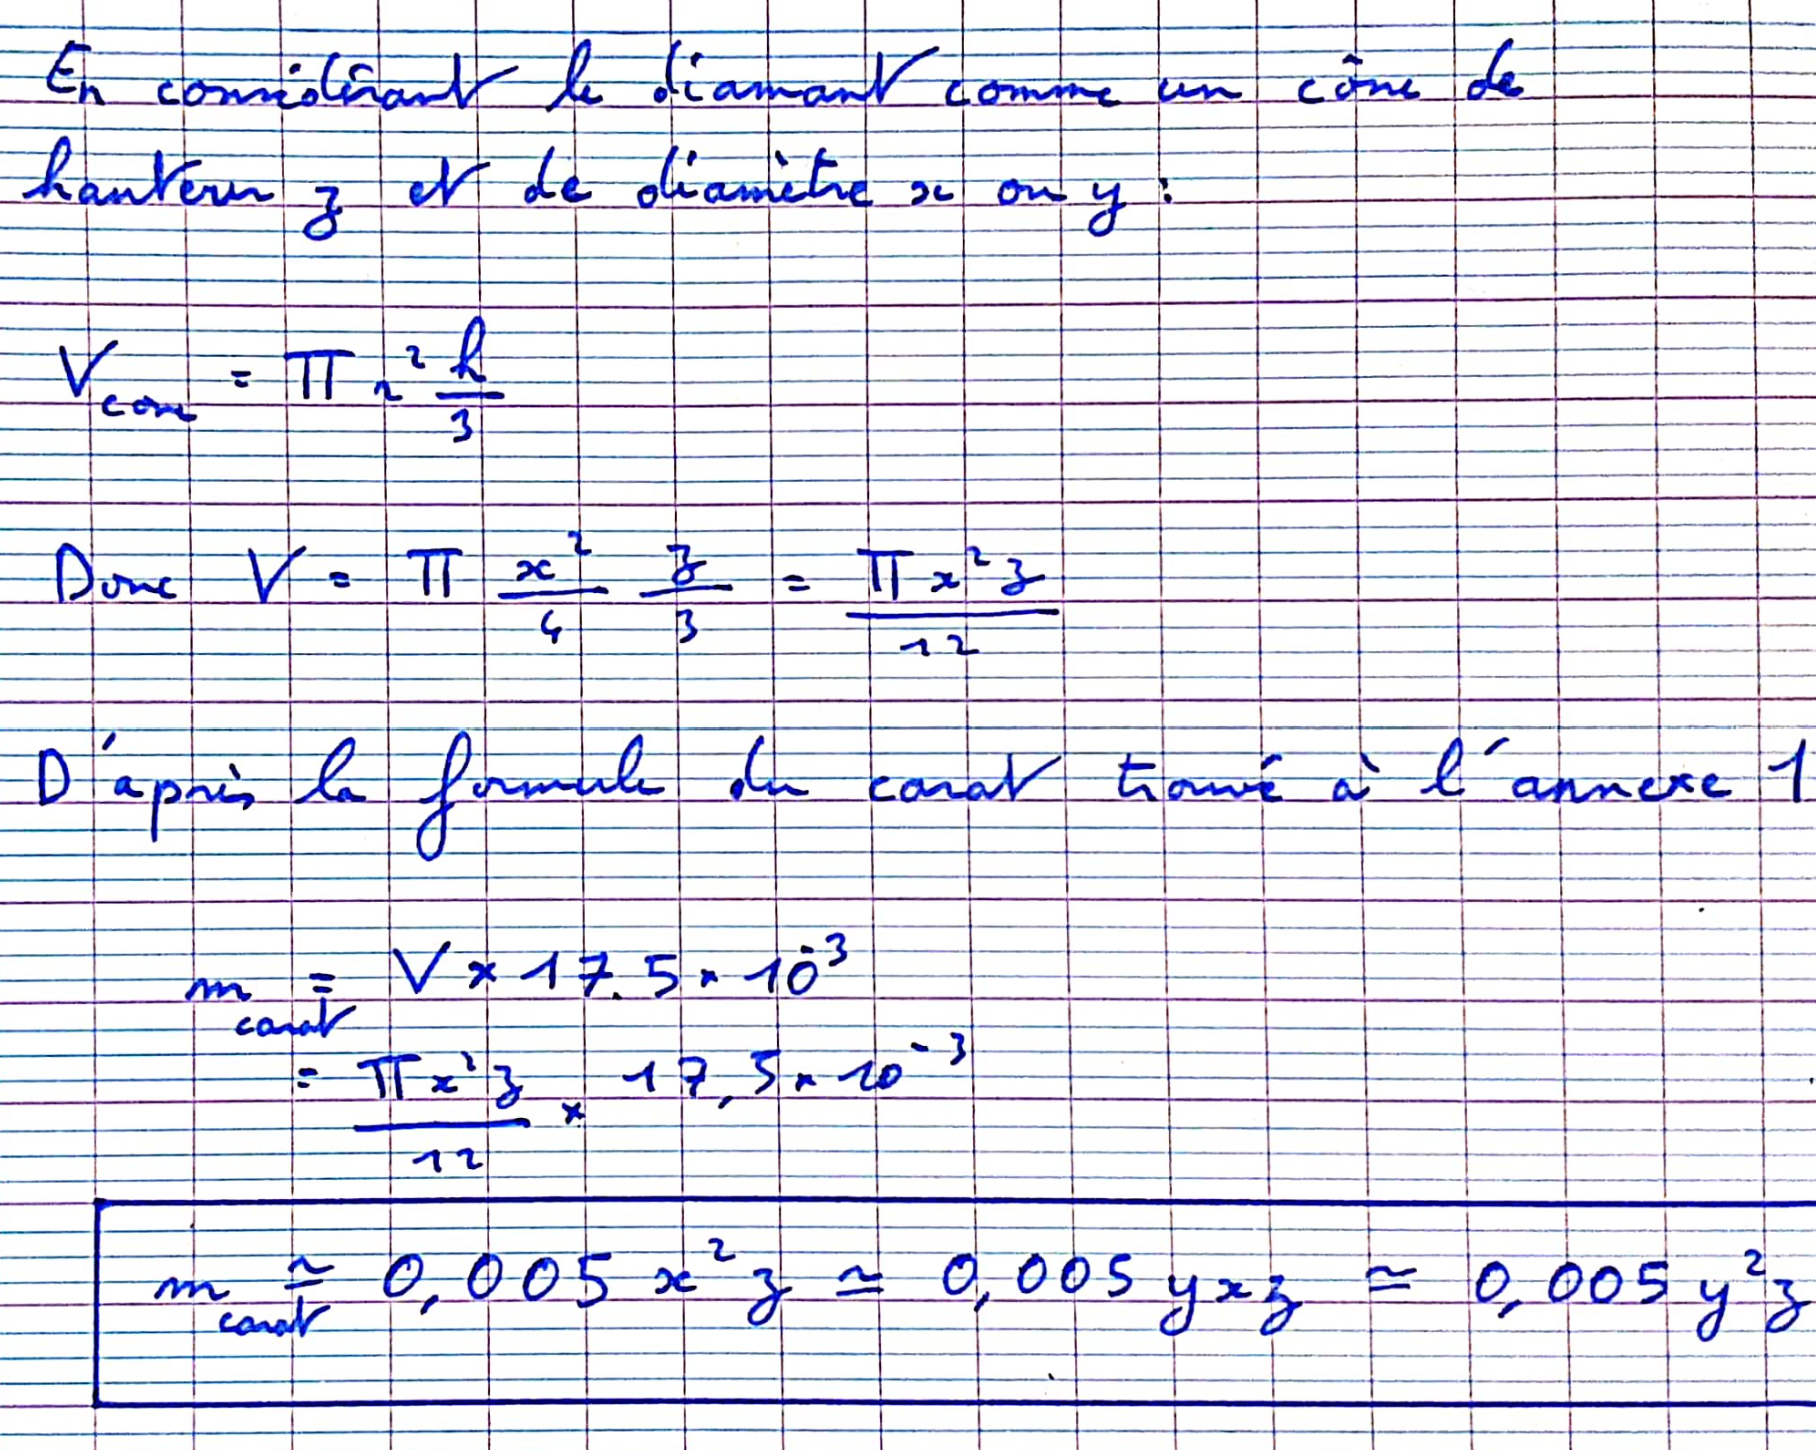

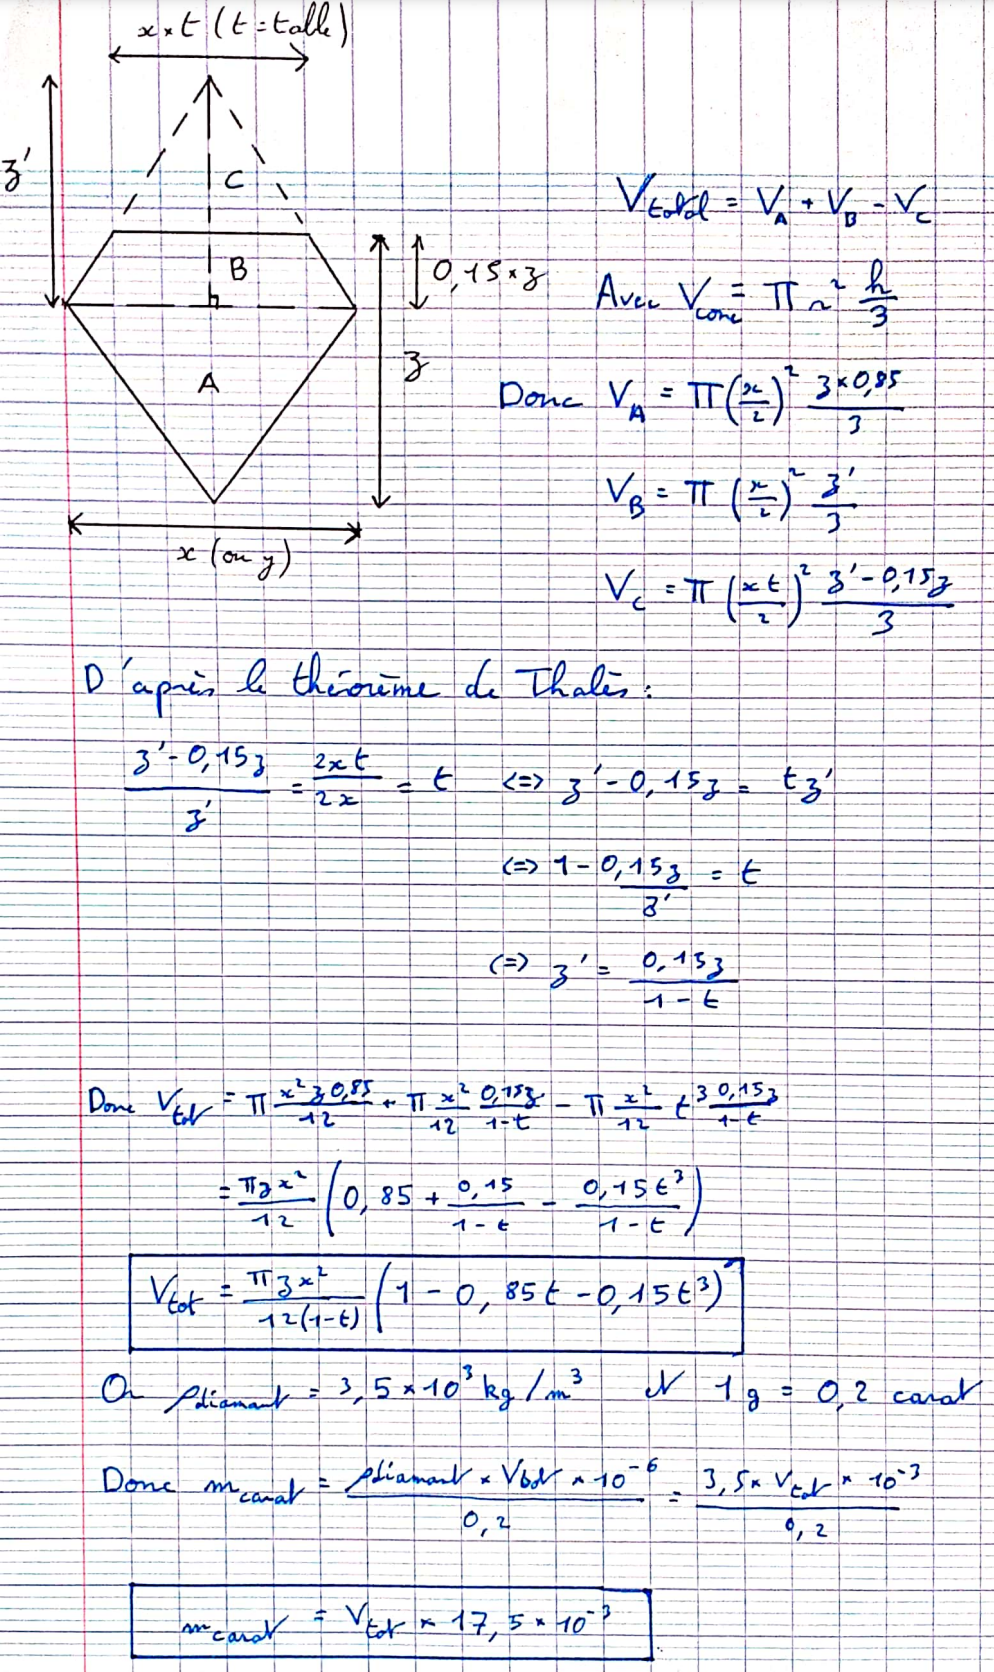